This block of code importing libraries necessary in data loading, data pre-processing, model definition, training and evaluate.

In [ ]:
import string
import re
from numpy import array, argmax, random, take
import pandas as pd
from keras.models import Sequential
from keras.layers import Dense, LSTM, Embedding, RepeatVector, Bidirectional, Attention, Input, Dropout
from keras.preprocessing.text import Tokenizer, tokenizer_from_json
from keras.callbacks import ModelCheckpoint
from keras.utils import pad_sequences
from keras.models import load_model
from keras import optimizers
import matplotlib.pyplot as plt
%matplotlib inline
pd.set_option('display.max_colwidth', 200)

Define the sentences filter function to remove sentences with special characters and exceeding maximum length.

In [ ]:
a = string.printable

sample_char = a[0:79]
sample_char += " "
sample_char += "–"

def sentences_filter(sentence, max_letters):
    state = True
    if (len(sentence) > max_letters):
      state = False
    else:
      for char in sentence:
        if char not in sample_char:
          state = False
          break
    return state

In [ ]:
# Mount Google Drive to Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


This block of code load data from file and then split the data by lines.

In [ ]:
# Split data in lines

data_dir = "/content/drive/MyDrive/Project/AI/data/PhoMT/tokenization/train/"
en_sents = open(data_dir + "train.en", "r").read().splitlines()
vi_sents = open(data_dir + "train.vi", "r").read().splitlines()


This block of code applies filter to each sentences, then assign the filtered sentences to a new dataset. Finally, it deletes old data variables for RAM optimization.



In [ ]:
# Data filtering

en_data = []
vi_data = []

sents_id = []

for i in range(len(en_sents)):
  if sentences_filter(en_sents[i], 200):
    sents_id.append(i)

for id in sents_id:
  en_data.append(en_sents[id])
  vi_data.append(vi_sents[id])

# Clean unnecessary variables from RAM

del en_sents, vi_sents, sents_id

In [ ]:
# Test data after filtering

print(en_data[100000])
print(vi_data[100000])


And we call that landmass Pangea .
Và chúng ta gọi vùng đất đó là Pangea .


In [ ]:
# Cut to small data.

sample_nums = 256000

en_data = en_data[:sample_nums]
vi_data = vi_data[:sample_nums]

In [ ]:
# function to build a tokenizer
def tokenization(lines):
    tokenizer = Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer

These two blocks of code below perform tokenization on both languages consecutively. Also, they define the maximum number of words in a sentence in data (the rest of words will be padded).

In [ ]:
import io
import json

# prepare english tokenizer
eng_tokenizer = tokenization(en_data)
eng_vocab_size = len(eng_tokenizer.word_index) + 1

eng_length = 40
print('English Vocabulary Size: %d' % eng_vocab_size)

eng_tokenizer_json = eng_tokenizer.to_json()
with io.open('/content/drive/MyDrive/Project/AI/tokenizer/eng_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(eng_tokenizer_json, ensure_ascii=False))

English Vocabulary Size: 52889


In [ ]:
# prepare vietnamese tokenizer
vi_tokenizer = tokenization(vi_data)
vi_vocab_size = len(vi_tokenizer.word_index) + 1

vi_length = 60
print('Vietnamese Vocabulary Size: %d' % vi_vocab_size)

vi_tokenizer_json = vi_tokenizer.to_json()
with io.open('/content/drive/MyDrive/Project/AI/tokenizer/vi_tokenizer.json', 'w', encoding='utf-8') as f:
    f.write(json.dumps(vi_tokenizer_json, ensure_ascii=False))

Vietnamese Vocabulary Size: 25732


This block of code define encoder function using pre-defined tokenizers and maximum sentence's length.

In [ ]:
# encode and pad sequences
def encode_sequences(tokenizer, length, lines):
    seq = tokenizer.texts_to_sequences(lines)
    # pad sequences with 0 values
    seq = pad_sequences(seq, maxlen=length, padding='post')
    return seq

Encode data for training.

In [ ]:
# prepare training data
trainX = encode_sequences(eng_tokenizer, eng_length, en_data)
trainY = encode_sequences(vi_tokenizer, vi_length, vi_data)

In [ ]:
# build NMT model
def define_model(in_vocab,out_vocab, in_timesteps,out_timesteps,units):
    model = Sequential()
    model.add(Embedding(in_vocab, units, input_length=in_timesteps, mask_zero=True))
    model.add(LSTM(units))
    model.add(RepeatVector(out_timesteps))
    model.add(LSTM(units, return_sequences=True))
    model.add(Dense(out_vocab, activation='softmax'))
    return model

In [ ]:
# model compilation
model = define_model(eng_vocab_size, vi_vocab_size, eng_length, vi_length, 512)

In [ ]:
rms = optimizers.RMSprop(lr=0.001)
model.compile(optimizer=rms, loss='sparse_categorical_crossentropy')

In [ ]:
model.summary()

Model: "sequential_13"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_15 (Embedding)    (None, 40, 512)           27079168  
                                                                 
 lstm_19 (LSTM)              (None, 512)               2099200   
                                                                 
 repeat_vector_7 (RepeatVect  (None, 60, 512)          0         
 or)                                                             
                                                                 
 lstm_20 (LSTM)              (None, 60, 512)           2099200   
                                                                 
 dense_6 (Dense)             (None, 60, 25732)         13200516  
                                                                 
Total params: 44,478,084
Trainable params: 44,478,084
Non-trainable params: 0
_________________________________________

In [ ]:
filename = '/content/drive/MyDrive/Project/AI/model/lstm_en_vi_1.1.h5'
checkpoint = ModelCheckpoint(filename, monitor='val_loss', verbose=1, save_best_only=True, mode='min')

# train model
history = model.fit(trainX, trainY.reshape(trainY.shape[0], trainY.shape[1], 1),
                    epochs=10, batch_size=512, validation_split = 0.2,callbacks=[checkpoint], 
                    verbose=1)

Epoch 1/10
400/400 [==============================] - ETA: 0s - loss: 2.3263
Epoch 1: val_loss improved from inf to 2.30503, saving model to /content/drive/MyDrive/Project/AI/model/lstm_en_vi_1.1.h5
400/400 [==============================] - 504s 1s/step - loss: 2.3263 - val_loss: 2.3050
Epoch 2/10
400/400 [==============================] - ETA: 0s - loss: 2.0791
Epoch 2: val_loss improved from 2.30503 to 2.26681, saving model to /content/drive/MyDrive/Project/AI/model/lstm_en_vi_1.1.h5
400/400 [==============================] - 502s 1s/step - loss: 2.0791 - val_loss: 2.2668
Epoch 3/10
400/400 [==============================] - ETA: 0s - loss: 1.9980
Epoch 3: val_loss improved from 2.26681 to 2.17605, saving model to /content/drive/MyDrive/Project/AI/model/lstm_en_vi_1.1.h5
400/400 [==============================] - 502s 1s/step - loss: 1.9980 - val_loss: 2.1760
Epoch 4/10
400/400 [==============================] - ETA: 0s - loss: 1.9213
Epoch 4: val_loss improved from 2.17605 to 2.108

In [ ]:
model = load_model('/content/drive/MyDrive/Project/AI/model/lstm_en_vi_1.1.h5')

In [ ]:
en_test = ["I am a human.", "She has two children.", "I have an apple", "he", "she", "water"]
vi_test = ["Tôi là một con người.", "Cô ấy có hai đứa trẻ.", "Tôi có một quả táo", "anh ấy", "cô ấy", "nước"]

testX = encode_sequences(eng_tokenizer, eng_length, en_test)
testY = encode_sequences(vi_tokenizer, vi_length, vi_test)

preds = argmax(model.predict(testX.reshape((testX.shape[0],testX.shape[1]))), axis=-1)

1/1 [==============================] - 2s 2s/step


In [ ]:
def get_word(n, tokenizer):
    for word, index in tokenizer.word_index.items():
        if index == n:
            return word
    return None

In [ ]:
preds_text = []
for i in preds:
    temp = []
    for j in range(len(i)):
        t = get_word(i[j], vi_tokenizer)
        if j > 0:
            if (t == get_word(i[j-1], vi_tokenizer)) or (t == None):
                temp.append('')
            else:
                temp.append(t)
        else:
            if(t == None):
                temp.append('')
            else:
                temp.append(t) 

    preds_text.append(' '.join(temp))

In [ ]:
pred_df = pd.DataFrame({'original': en_test,'actual' : vi_test, 'predicted' : preds_text})

In [ ]:
pred_df.head(7)

,original,actual,predicted
0,I am a human.,Tôi là một con người.,tôi là một người
1,She has two children.,Cô ấy có hai đứa trẻ.,cô bé có hai trẻ
2,I have an apple,Tôi có một quả táo,tôi có một
3,he,anh ấy,anh
4,she,cô ấy,cô
5,water,nước,có nước


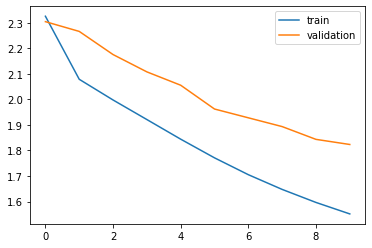

In [ ]:
# Plot loss
fig = plt.figure
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.legend(['train','validation'])

#then save it
plt.savefig('/content/drive/MyDrive/Project/AI/final/loss_graph.png', dpi=900)

#finally .show() or .draw() it in this order
plt.show()